In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import OrderedDict
import pandas_ta as ta

base_time = datetime.strptime("00:00:00", "%H:%M:%S")
df = pd.read_parquet("combined1minutedata.parquet")
df["underlying_price"] = df["underlying_price"].astype(float)
df.loc[:, "time"] = df["ms_of_day"].apply(
    lambda ms_of_day: (base_time + timedelta(milliseconds=ms_of_day)).time()
)
df.set_index(["date", "time"], inplace=True)

In [46]:
ROLLING_WINDOW = 30

def garch_calc(rtn):
    am = arch_model(rtn.dropna().values*100)
    res = am.fit(disp="off")
    forecasts = res.forecast(horizon=5)
    # 390 minutes per day
    vol_forecast = (
        forecasts.residual_variance.iloc[-1, :].sum() * 390 / 5
    ) ** 0.5 / 100
    return vol_forecast

def sigma(price, method="garch"):
    if method == "hist":
        return (price.pct_change()*100).std() * (390**0.5)
    elif method == "garch":
        return garch_calc(price.pct_change()*100)
    elif method == "realized":
        return np.sqrt(((price.pct_change()*100)**2).sum()) * np.sqrt(
            390
        )


def find_strike(underlying_price, strike, callput="C", spread=0):
    sign = 1 if callput == "C" else -1
    if len(underlying_price) == 0:
        print("Invalid underlying_price")
        return np.nan
    if len(strike) == 0:
        print("Invalid strike")
        return np.nan

    price = underlying_price.iloc[0]
    while True:
        closest_index = np.argmin(np.abs((strike.values - price))) + sign * spread
        if abs(closest_index) < len(strike):
            closest_value = strike.iloc[closest_index]
            break
        else:
            # closest_value = strike.iloc[closest_index - sign * spread]
            spread = spread - 1

    return closest_value


def iv_on_spread(df):
    df_iv = pd.DataFrame()
    for spread in range(0, 5):
        atm_iv_col_name = f"atm_plus_{spread}spread_iv"
        atm_col_name = f"atm_plus_{spread}spread"
        df_day_call = df.loc[df["right"] == "C"].reset_index().set_index("time")
        df_day_call.loc[:, atm_col_name] = df_day_call.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "C", spread=spread
            )
        )
        df_iv_call = df_day_call.loc[
            df_day_call["strike"] == df_day_call[atm_col_name]
        ]["implied_vol"].to_frame()
        df_iv_call.columns = [atm_iv_col_name + "_CALL"]

        df_day_put = df.loc[df["right"] == "P"].reset_index().set_index("time")
        df_day_put.loc[:, atm_col_name] = df_day_put.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "P", spread=spread
            )
        )
        df_iv_put = df_day_put.loc[df_day_put["strike"] == df_day_put[atm_col_name]][
            "implied_vol"
        ].to_frame()
        df_iv_put.columns = [atm_iv_col_name + "_PUT"]

        df_iv = pd.concat(
            [
                df_iv,
                df_iv_call,
                df_iv_put,
            ],
            axis=1,
        )

    return df_iv


def pnl_on_spread(df):
    df_pnl = pd.DataFrame()
    for spread in range(0, 5):
        atm_col_name = f"atm_plus_{spread}spread"
        atm_pnl_col_name = f"atm_plus_{spread}spread_pnl"
        df_day_call = df.loc[df["right"] == "C"].reset_index().set_index("time")

        df_day_call.loc[:, atm_col_name] = df_day_call.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "C", spread=spread
            )
        )

        df_pnl_call = df_day_call.loc[
            df_day_call["strike"] == df_day_call[atm_col_name]
        ]["EOD_PnL"].to_frame()

        df_day_put = df.loc[df["right"] == "P"].reset_index().set_index("time")
        df_day_put.loc[:, atm_col_name] = df_day_put.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "P", spread=spread
            )
        )

        df_pnl_put = df_day_put.loc[df_day_put["strike"] == df_day_put[atm_col_name]][
            "EOD_PnL"
        ].to_frame()

        df_pnl_sum_spread = df_pnl_call + df_pnl_put
        df_pnl_sum_spread.columns = [atm_pnl_col_name]

        df_pnl = pd.concat(
            [df_pnl, df_pnl_sum_spread],
            axis=1,
        )
    return df_pnl


def underlying_ohlc(df):
    df_price=df.groupby(["date", "time"])["underlying_price"].first().reset_index()
    # Combine date and time into a single datetime column
    df_price["datetime"] = pd.to_datetime(df_price["date"].astype(str) + " " + df_price["time"].astype(str))

    # Set the datetime column as the index
    df_price.set_index("datetime", inplace=True)

    # Drop the original date and time columns (optional)
    df_price.drop(columns=["date", "time"], inplace=True)

    # Resample to daily OHLC
    ohlc_dict = {
        "price": {
            "open": "first",  # First price of the day
            "high": "max",  # Highest price of the day
            "low": "min",  # Lowest price of the day
            "close": "last",  # Last price of the day
        }
    }

    # Resample and aggregate
    df_ohlc = (
        df_price["underlying_price"]
        .resample("D")
        .agg(
            OrderedDict(
                [
                    ("open", "first"),
                    ("high", "max"),
                    ("low", "min"),
                    ("close", "last"),
                ]
            )
        )
    ).dropna(axis=0)

    df_ohlc.index.name = "date"
    # Display the result
    return df_ohlc

def daily_atr(df,window=14):
    df_ohlc = underlying_ohlc(df)
    df_atr = df_ohlc.ta.atr(window, fillna=0)
    return df_atr

def plot_volatility(df, df_iv, df_pnl, DAY):
    # Convert index to datetime
    df.index = pd.to_datetime(df.index, format="%H:%M:%S", errors="coerce")
    df_iv.index = pd.to_datetime(df_iv.index, format="%H:%M:%S", errors="coerce")
    df_pnl.index = pd.to_datetime(df_pnl.index, format="%H:%M:%S", errors="coerce")

    # Create a figure with 3 subplots (3 rows, 1 column)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Plot 1: Volatility and Price (Primary Plot)
    ax1.plot(df.index, df["Garch_Vlty"], color="blue", label="Garch Volatility")
    ax1.plot(df.index, df["Hist_Vlty"], color="green", label="Historical Volatility")
    ax1.set_ylabel("Volatility", color="blue")
    ax1.tick_params(axis="y", colors="blue")

    # Secondary y-axis for Price
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(df.index, df["Price"], color="red", label="Price")
    ax1_secondary.plot(df.index, df["Price"].iloc[0]+0.5 * df["atr"], color="orange", label=f"+1/2 ATR {int(df['atr'].iloc[0]/2)}")
    ax1_secondary.plot(
        df.index,
        df["Price"].iloc[0] - 0.5 * df["atr"],
        color="pink",
        label=f"-1/2 ATR {int(df['atr'].iloc[0]/2)}",
    )
    ax1_secondary.set_ylabel("Price", color="red")
    ax1_secondary.tick_params(axis="y", colors="red")

    # Add legends for the first subplot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_secondary.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # Plot 2: Implied Volatility (df_iv)
    # Use unique colors and labels for each line in df_iv
    for col in df_iv.columns:
        ax2.plot(df_iv.index, df_iv[col], label=f"{col}")
    ax2.set_ylabel("Implied Volatility", color="purple")
    ax2.tick_params(axis="y", colors="purple")
    ax2.legend(loc="upper left")

    # Plot 3: PnL (df_pnl)
    # Use unique colors and labels for each line in df_pnl
    for col in df_pnl.columns:
        ax3.plot(df_pnl.index, df_pnl[col], label=f"{col}")
    ax3.set_ylabel("PnL", color="orange")
    ax3.tick_params(axis="y", colors="orange")
    ax3.legend(loc="upper left")

    # Customize x-axis for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Ticks every hour
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM
        ax.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Set common x-axis label
    ax3.set_xlabel("Time")

    # Add a title for the entire figure
    fig.suptitle(
        f"Volatility, Price, Implied Volatility, and PnL Over Time on {DAY}",
        fontsize=14,
    )

    # Improve layout
    plt.tight_layout()
    plt.show()

In [47]:
def chart_by_day(DAY):
    df_day_price = df.groupby(["date", "time"])["underlying_price"].first()
    df_vlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="garch"))
        .reset_index()
        .set_index("time")
    )
    df_histvlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="hist"))
        .reset_index()
        .set_index("time")
    )

    df_price = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .reset_index()
        .set_index("time")
    )

    df_iv = iv_on_spread(df.loc[(df.index.get_level_values(0) == DAY)])
    df_pnl = pnl_on_spread(df.loc[(df.index.get_level_values(0) == DAY)])

    df_vlty = pd.concat(
        [
            df_vlty["underlying_price"],
            df_histvlty["underlying_price"],
            df_price["underlying_price"],
        ],
        axis=1,
    )
    df_vlty.columns = ["Garch_Vlty", "Hist_Vlty", "Price"]
    df_vlty = df_vlty.fillna(0)
    df_daily_atr = daily_atr(df)
    df_vlty["atr"] = df_daily_atr.loc[df_daily_atr.index.get_level_values(0) == DAY].values[0]
    plot_volatility(df_vlty, df_iv, df_pnl, DAY=DAY)

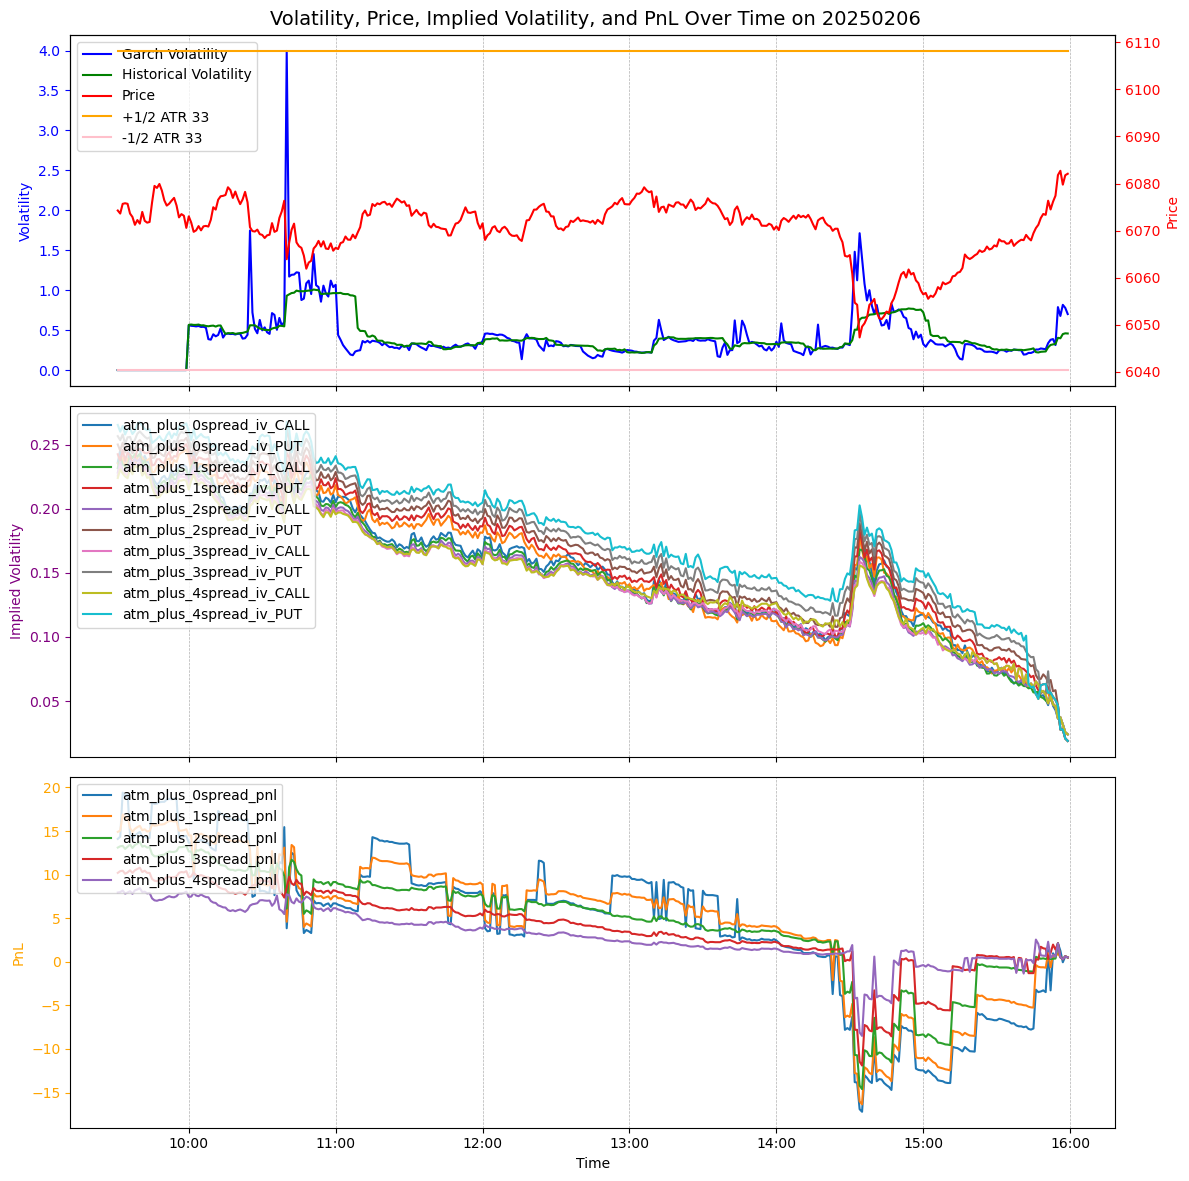

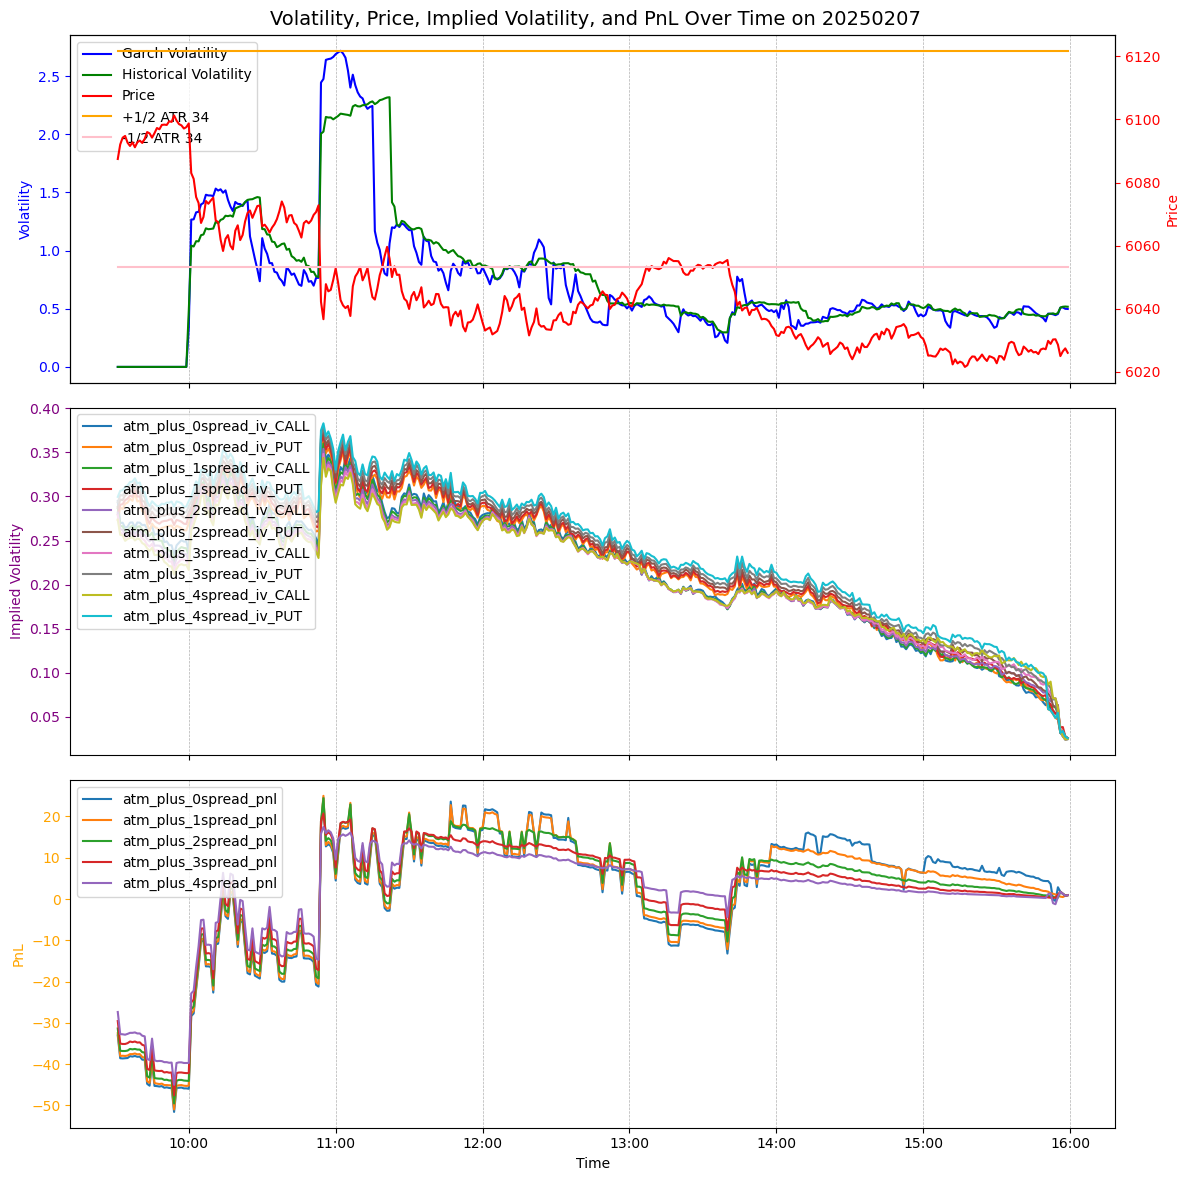

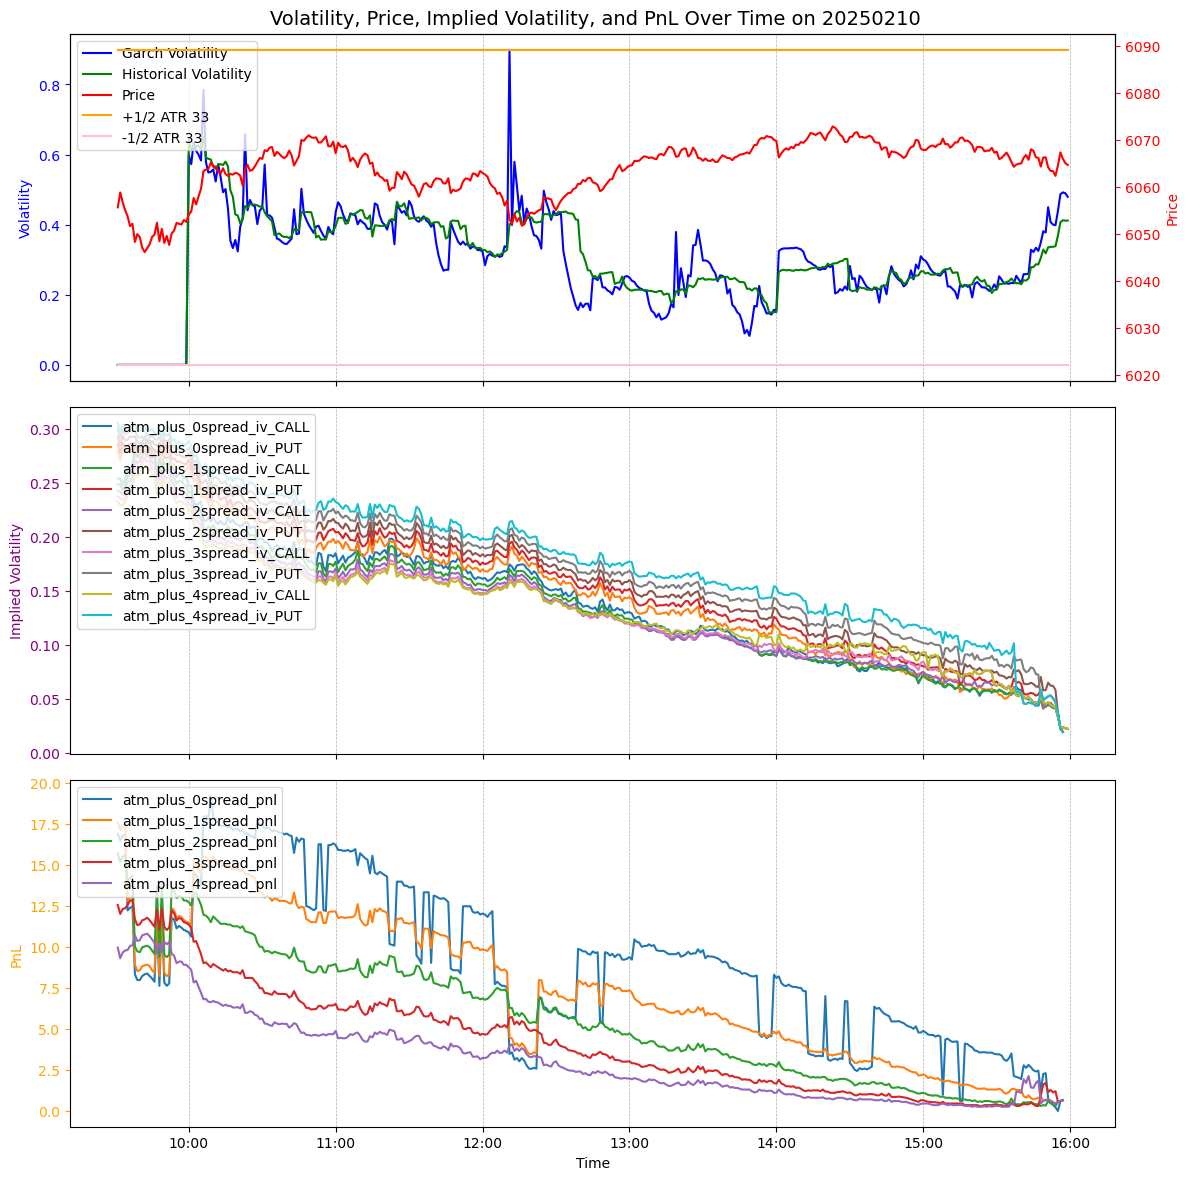

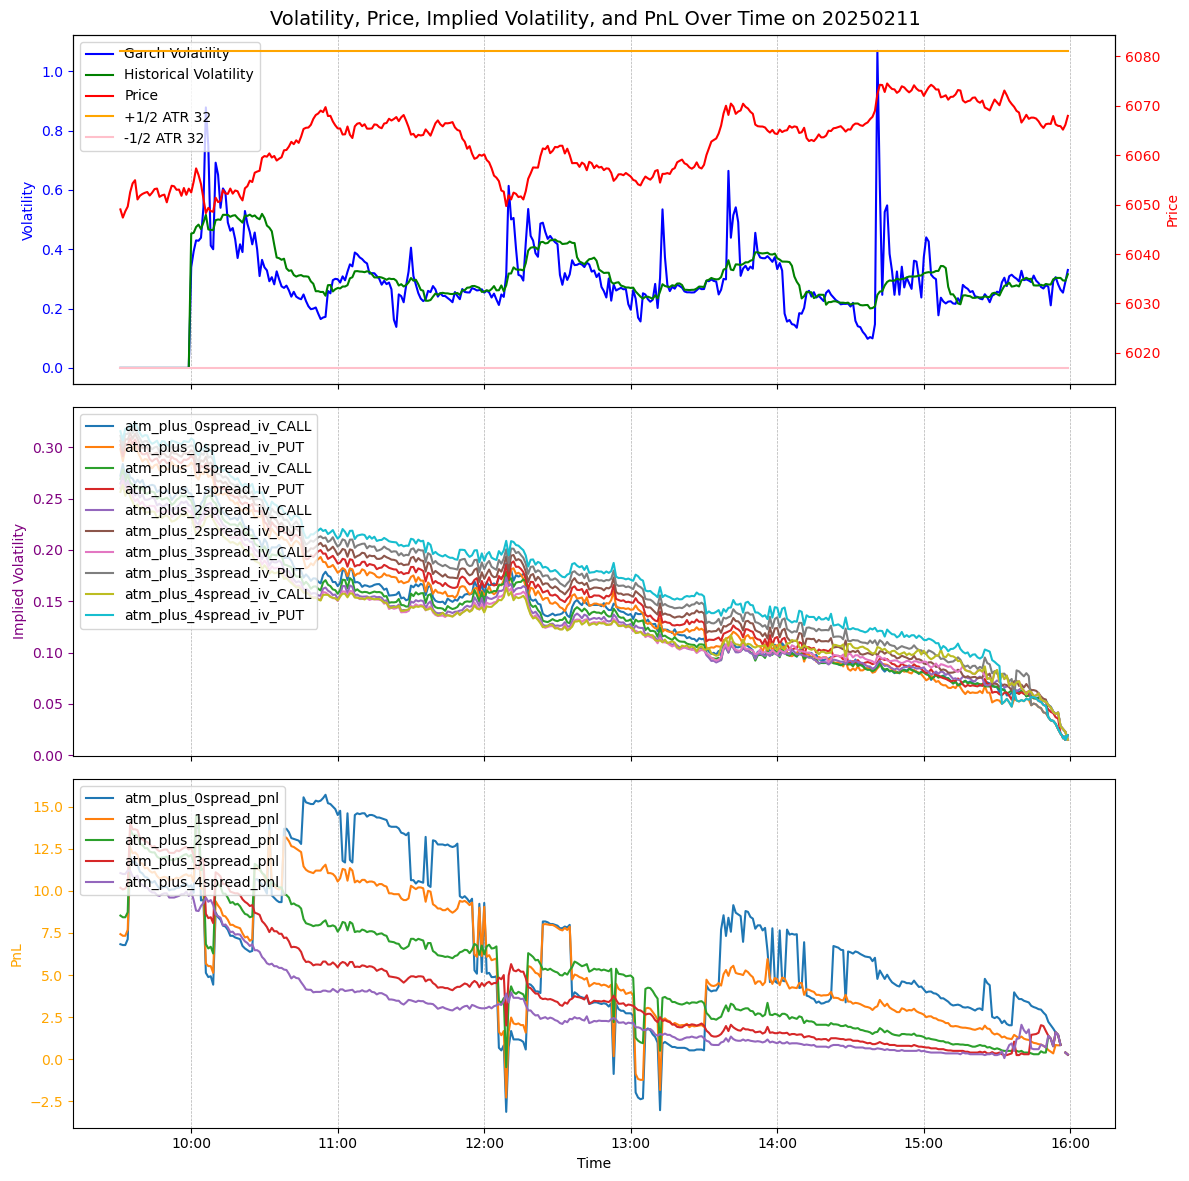

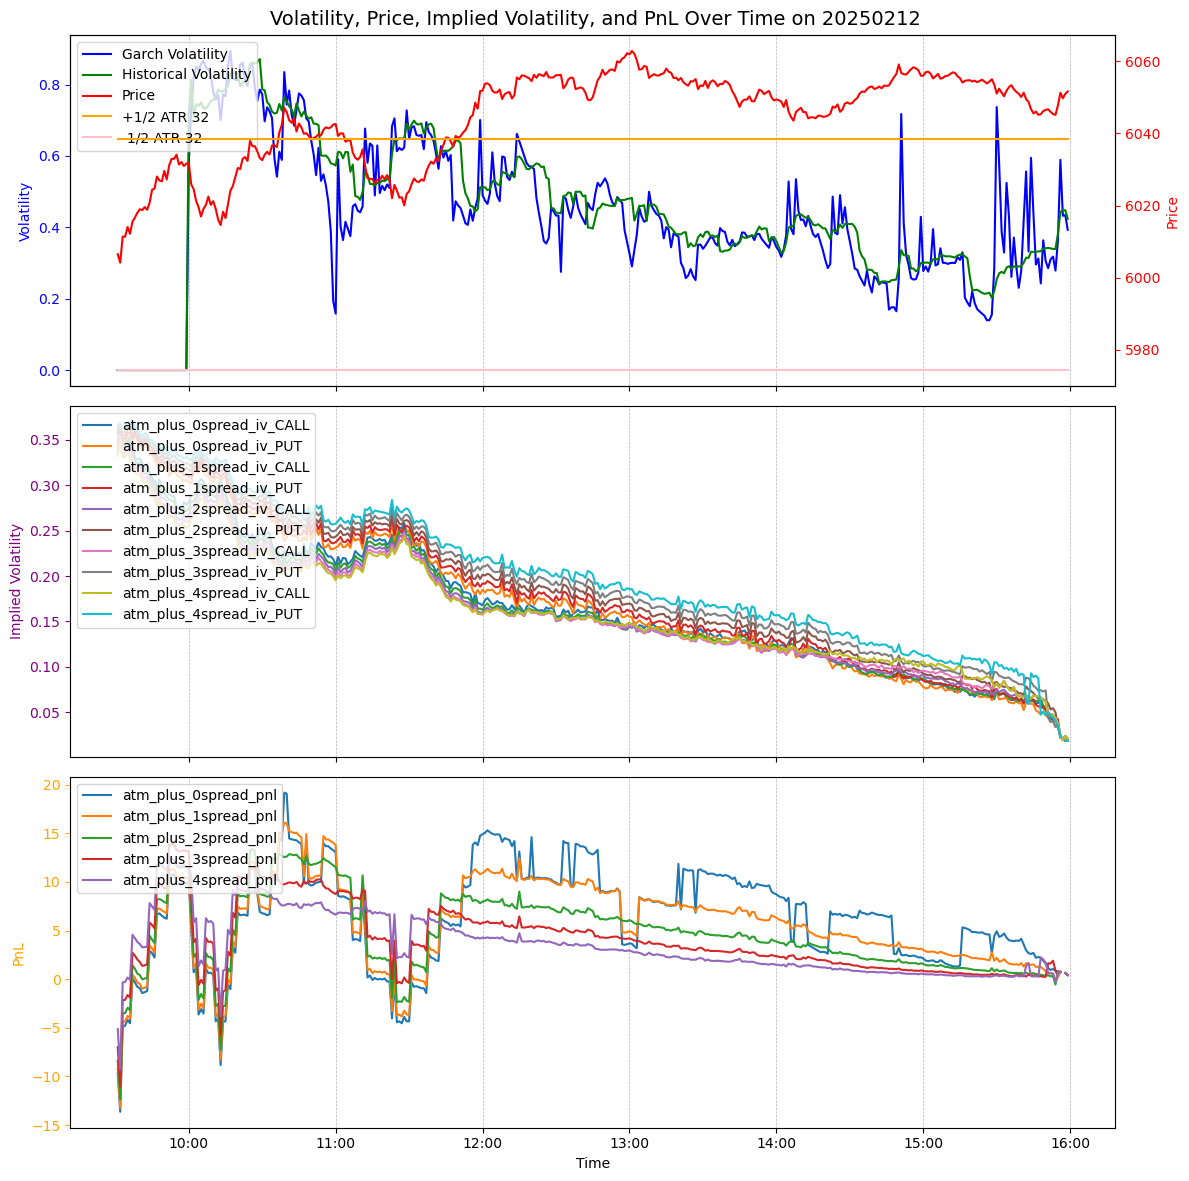

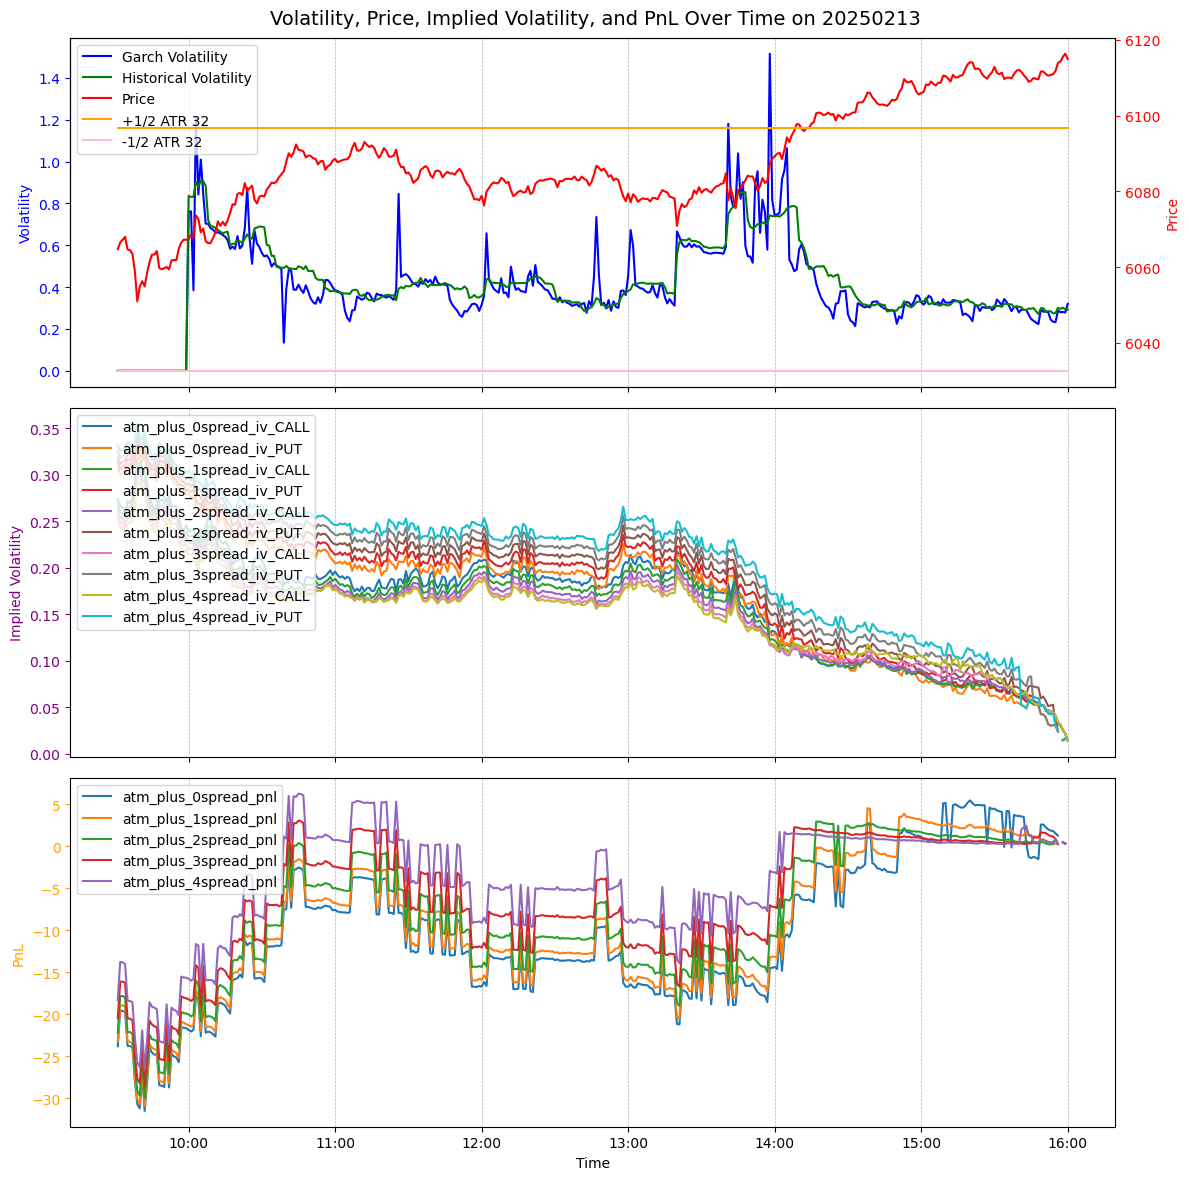

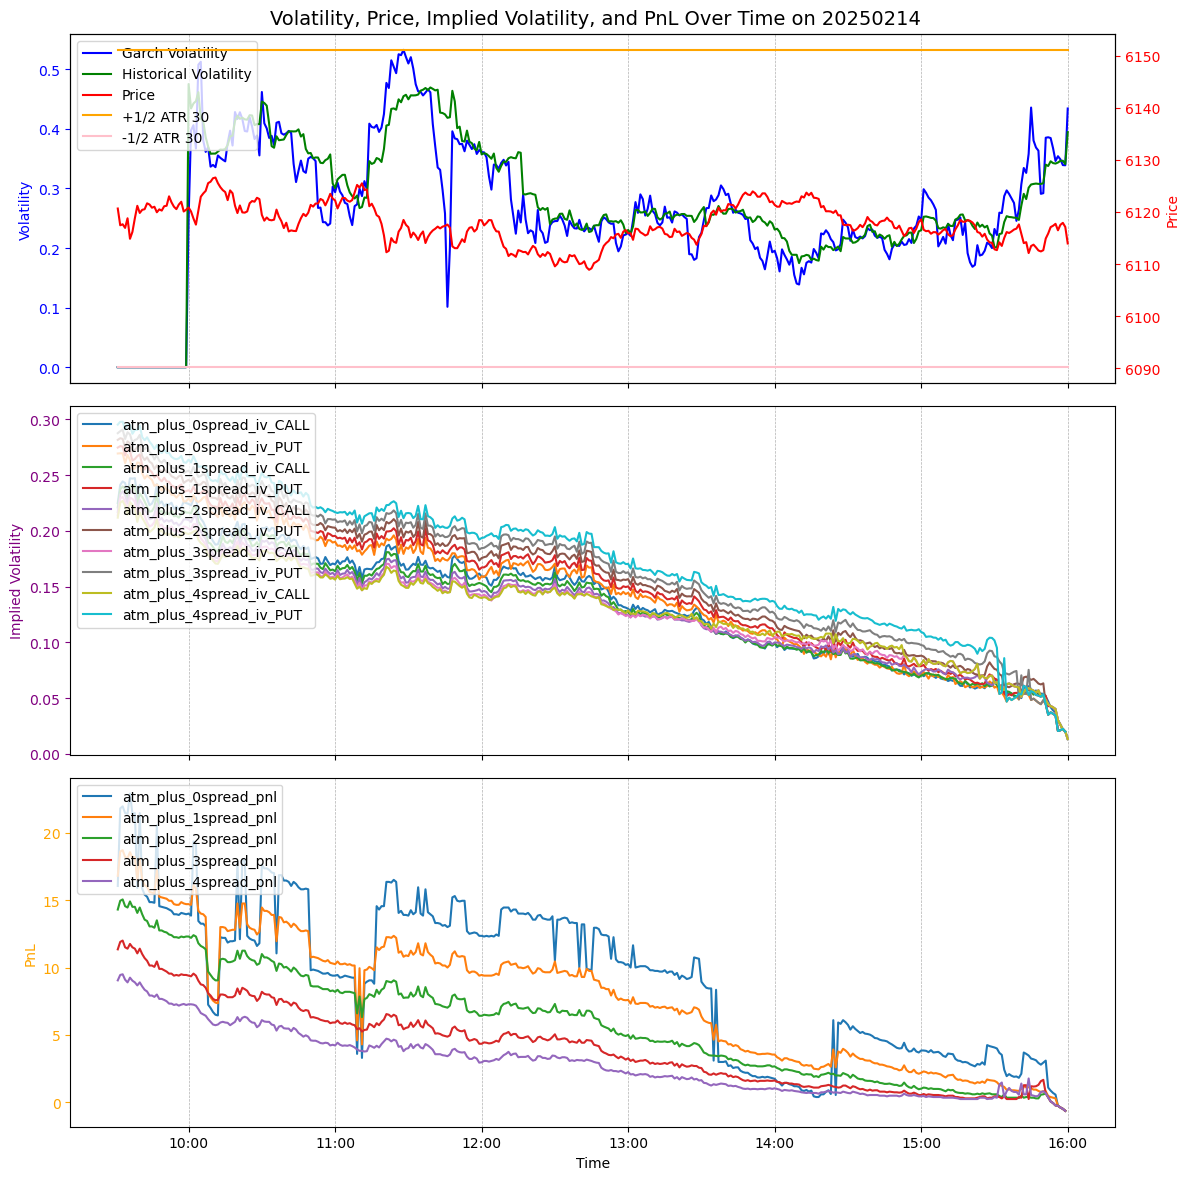

In [48]:
chart_by_day("20250206")
chart_by_day("20250207")
chart_by_day("20250210")
chart_by_day("20250211")
chart_by_day("20250212")
chart_by_day("20250213")
chart_by_day("20250214")

In [29]:
df_day.loc[:, "extrinsic"] = (
    np.maximum(0, df_day["underlying_price"] - df_day["strike"]) + df_day["mid"]
)


NameError: name 'df_day' is not defined